In [1]:
import time
import gc

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt 

from py.od_perturber import od_perturber
from py.output_reader import output_reader
from py.tap_trial import tap_trial

# Austin case study

This network represents the city of Austin, TX in the early 2000s. Suppose there was some uncertainty about how the city would grow in the next 10 years, how would that affect the output metrics and, consequently, the ranking of different investment alternatives?

In [2]:
net = 'Austin_sdb'
netFilename = 'inputs/{}_net.txt'.format(net)
tripsFilename = 'inputs/{}_trips.txt'.format(net)

ten_year_growth_factor = lambda x: x**10
ten_year_growth_factor(1.01)

1.1046221254112045

## Scenario 1: 2.08% annual growth

In [3]:
start = time.time()
df208, tstt208, wvc208, vmt208, demand208, od208 = tap_trial(
    netFilename, tripsFilename, norm_mean=ten_year_growth_factor(1.0208), norm_sd=0, returnDataFrame=True, returnODinfo=True)
runtime208 = time.time()-start
print('Time elapsed: {:.2f}s'.format(runtime208))
print('Total demand: {}'.format(demand208))
print('        TSTT: {}'.format(tstt208))
print('Weighted V/C: {}'.format(wvc208))
print('         VMT: {}'.format(vmt208))
df208.head()

Time elapsed: 1598.66s
Total demand: 853885.3223849998
        TSTT: 36996508.96022457
Weighted V/C: 0.00010476767283306195
         VMT: 41205462526.42639


,flow,cost,der,capacity,length
link,,,,,
"(3782,3783)",13061.852953,0.943119,0.000226,5900.0,739.2
"(3843,3833)",12188.989281,1.201671,0.000289,5900.0,1161.6
"(3832,3850)",11836.898348,1.003950,0.000240,5900.0,1056.0
"(3783,3843)",11909.253411,0.817201,0.000196,5900.0,844.8
"(3873,3874)",12003.241188,0.731347,0.000175,5900.0,739.2


In [4]:
ref_flows = df208['flow']
vc = df208['flow']/df208['capacity']
most_congested_link_id = vc.idxmax()
ref_most_congested_link_vc = vc.max()
del vc
df208.loc[(df208['flow']).sort_values(ascending=False).index,].head()

,flow,cost,der,capacity,length
link,,,,,
"(4163,3555)",26802.079904,0.657540,0.000078,11800.0,475.2
"(4162,4163)",26271.922820,1.577169,0.000189,11800.0,1214.4
"(3555,3556)",26017.925524,2.527636,0.000303,11800.0,2006.4
"(4281,6130)",25133.267563,0.538309,0.000065,11800.0,475.2
"(6130,4162)",25133.267563,1.136430,0.000137,11800.0,1003.2


## Scenario 2: 3% annual growth

In [5]:
start = time.time()
df3, tstt3, wvc3, vmt3, rmse3, mclvc3, demand3, od3 = tap_trial(
    netFilename, tripsFilename, norm_mean=ten_year_growth_factor(1.03), norm_sd=0, 
    true_flows=ref_flows, focus_link = most_congested_link_id,
    returnDataFrame=True, returnODinfo=True)
runtime3 = time.time()-start
print('Time elapsed: {:.2f}s'.format(runtime3))
print('Total demand: {}'.format(demand3))
print('        TSTT: {}'.format(tstt3))
print('Weighted V/C: {}'.format(wvc3))
print('         VMT: {}'.format(vmt3))
print('  Flows RMSE: {}'.format(rmse3))
print('Fcs link V/C: {}'.format(mclvc3))
df3.head()

Time elapsed: 1690.40s
Total demand: 934039.315658
        TSTT: 51753442.94129026
Weighted V/C: 0.00011361574793320284
         VMT: 45352622967.527405
  Flows RMSE: 267.9731985759682
Fcs link V/C: 8.290043634285714


,flow,cost,der,capacity,length
link,,,,,
"(3782,3783)",14228.948198,1.244487,0.000292,5900.0,739.2
"(3843,3833)",13252.883859,1.551413,0.000371,5900.0,1161.6
"(3832,3850)",12774.772193,1.257608,0.000302,5900.0,1056.0
"(3783,3843)",12962.659322,1.052512,0.000253,5900.0,844.8
"(3873,3874)",13113.697463,0.954910,0.000229,5900.0,739.2


In [6]:
df3.loc[(df3['flow']).sort_values(ascending=False).index,].head(10)

,flow,cost,der,capacity,length
link,,,,,
"(4163,3555)",29285.289744,0.881207,0.000102,11800.0,475.2
"(4162,4163)",28666.902033,2.095245,0.000245,11800.0,1214.4
"(3555,3556)",28295.578821,3.314063,0.000390,11800.0,2006.4
"(6130,4162)",27377.349072,1.486558,0.000177,11800.0,1003.2
"(4281,6130)",27377.349072,0.704159,0.000084,11800.0,475.2
"(4298,4249)",26099.847043,2.552584,0.000306,11800.0,2006.4
"(6154,4281)",25411.648244,1.113250,0.000134,11800.0,950.4
"(4300,4298)",24402.630805,1.260018,0.000151,11800.0,1214.4
"(4246,4280)",22702.861048,1.207236,0.000143,11800.0,1425.6


## Scenario 3: Geospatially adjusted growth

Suppose we had more precision in our estimates, allowing us to apply different growth factors to different sections of the city.

In [7]:
gfs = { # 5 different regions of the city correspond to three different scaling factors
    15: ten_year_growth_factor(1.0275), #west and central code to 1 and 5, respectively
    23: ten_year_growth_factor(1.0325), #south and north code to 2 and 3, respectively
    4: ten_year_growth_factor(1.03) #east codes to 4
}

df = pd.read_excel('inputs/ATX_PARTITIONED.xlsx', index_col=0)
df.head(50)

,X,Y,Field4
Node,,,
1,-97861763,30550045,1
2,-97873341,30595955,3
3,-97842574,30537706,3
4,-97967226,30531993,1
5,-97901257,30496550,1
6,-97882086,30460701,1
7,-97827879,30498174,1
8,-98083907,30434403,1
9,-98053644,30488843,1


In [8]:
west_central = set(df[(df['Field4']==1) | (df['Field4']==5)].index.tolist())
south_north = set(df[(df['Field4']==2) | (df['Field4']==3)].index.tolist())
east = set(df[(df['Field4']==4)].index.tolist())
assert(len(west_central) + len(south_north) + len(east) == df.shape[0])

In [9]:
start = time.time()
od_perturber(tripsFilename, 'normal', norm_mean=gfs[15], norm_sd=0, nodesPerturbedIfOrig=west_central)
od_perturber('trips_perturbed.tntp', 'normal', norm_mean=gfs[23], norm_sd=0, nodesPerturbedIfOrig=south_north)
dfr, tsttr, wvcr, vmtr, rmser, mclvcr, demandr, odr = tap_trial(
    netFilename, 'trips_perturbed.tntp', norm_mean=gfs[4], norm_sd=0, nodesPerturbedIfOrig=east, 
    true_flows=ref_flows, focus_link = most_congested_link_id,
    returnDataFrame=True, returnODinfo=True)
runtimer = time.time()-start
print('Time elapsed: {:.2f}s'.format(runtimer))
print('Total demand: {}'.format(demandr))
print('        TSTT: {}'.format(tsttr))
print('Weighted V/C: {}'.format(wvcr))
print('         VMT: {}'.format(vmtr))
print('   Flow RMSE: {}'.format(rmser))
print('Fcs link V/C: {}'.format(mclvcr))
dfr.head()

Time elapsed: 1664.71s
Total demand: 939298.0849039998
        TSTT: 51128105.50654777
Weighted V/C: 0.00011410963454885911
         VMT: 45702076517.221504
   Flow RMSE: 287.3213310644877
Fcs link V/C: 8.091012894285713


,flow,cost,der,capacity,length
link,,,,,
"(3782,3783)",14241.938767,1.248289,0.000293,5900.0,739.2
"(3843,3833)",13245.472107,1.548665,0.000370,5900.0,1161.6
"(3832,3850)",12749.619312,1.250031,0.000300,5900.0,1056.0
"(3783,3843)",12974.618194,1.055536,0.000253,5900.0,844.8
"(3873,3874)",13134.530035,0.959687,0.000230,5900.0,739.2


## Observe variance in link ranking

In [10]:
dfr.loc[(dfr['flow']).sort_values(ascending=False).index,].head(10)

,flow,cost,der,capacity,length
link,,,,,
"(4163,3555)",29381.921494,0.891149,0.000103,11800.0,475.2
"(4162,4163)",28761.339145,2.118534,0.000248,11800.0,1214.4
"(3555,3556)",28375.710930,3.345438,0.000393,11800.0,2006.4
"(6130,4162)",27474.250483,1.503759,0.000178,11800.0,1003.2
"(4281,6130)",27474.250483,0.712307,0.000085,11800.0,475.2
"(4298,4249)",26256.612882,2.600984,0.000312,11800.0,2006.4
"(6154,4281)",25502.050591,1.125408,0.000135,11800.0,950.4
"(4300,4298)",24639.564912,1.296408,0.000156,11800.0,1214.4
"(4246,4280)",22808.817774,1.222503,0.000145,11800.0,1425.6


In [11]:
df3.loc[(df3['flow']).sort_values(ascending=False).index,].head(10)

,flow,cost,der,capacity,length
link,,,,,
"(4163,3555)",29285.289744,0.881207,0.000102,11800.0,475.2
"(4162,4163)",28666.902033,2.095245,0.000245,11800.0,1214.4
"(3555,3556)",28295.578821,3.314063,0.000390,11800.0,2006.4
"(6130,4162)",27377.349072,1.486558,0.000177,11800.0,1003.2
"(4281,6130)",27377.349072,0.704159,0.000084,11800.0,475.2
"(4298,4249)",26099.847043,2.552584,0.000306,11800.0,2006.4
"(6154,4281)",25411.648244,1.113250,0.000134,11800.0,950.4
"(4300,4298)",24402.630805,1.260018,0.000151,11800.0,1214.4
"(4246,4280)",22702.861048,1.207236,0.000143,11800.0,1425.6


In [12]:
df3.to_csv('output/data/austin_scale_regional.csv')

## Plot changes between the three scenarios

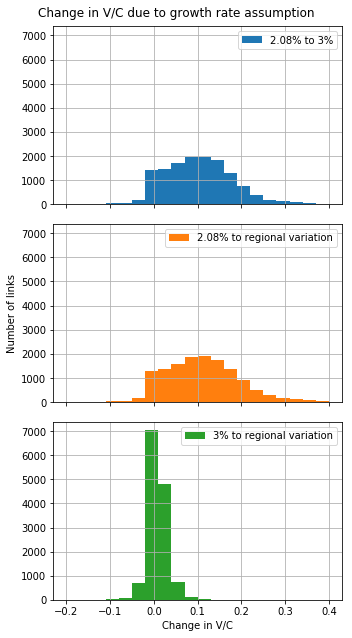

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5,9), sharex=True, sharey=True)
bins = 20
rg = (-0.2, 0.4)
vc208 = (df208['flow']/df208['capacity'])
vc3 = (df3['flow']/df3['capacity'])
vcr = (dfr['flow']/dfr['capacity'])
plt.sca(axes[0])
(vc3 - vc208).hist(bins=bins, range=rg, label='2.08% to 3%')
# axes[0].set_ylabel('2.08% to 3%')
axes[0].legend()
plt.sca(axes[1])
(vcr - vc208).hist(bins=bins, range=rg, label='2.08% to regional variation', color=u'#ff7f0e')
# axes[1].set_ylabel('2.08% to regional variance')
axes[1].legend()
axes[1].set_ylabel('Number of links')
plt.sca(axes[2])
(vcr - vc3).hist(bins=bins, range=rg, label='3% to regional variation', color=u'#2ca02c')
# axes[2].set_ylabel('3% to regional variance')
axes[2].legend()
axes[2].set_xlabel('Change in V/C')
fig.suptitle('Change in V/C due to growth rate assumption')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('output/plots/Austin_hists.png', dpi='figure')
plt.show()

# Base case

In [58]:
start = time.time()
df0, tstt0, wvc0, demand0, od0 = tap_trial(netFilename, tripsFilename, norm_mean=1, norm_sd=0, returnDataFrame=True, returnODinfo=True)
print(time.time()-start)
df0.head()

906.0825982093811


,flow,cost,der,capacity
link,,,,
"(719,1259)",20.0,0.24,0.0,100000.0
"(1259,719)",1.0,0.24,0.0,100000.0
"(909,1260)",7.0,0.28,0.0,100000.0
"(1260,909)",38.0,0.28,0.0,100000.0
"(705,1528)",169.0,0.64,0.0,100000.0


In [64]:
df0.to_csv('output/data/austin_scale_1.csv')